# When will the Cherry Trees bloom?
### Cherry Blossom Prediction Competition by Department of Statistics, George Mason University
##### By Dr. Zeehasham Rasheed
##### Adjunct Professor, CS and IST Departments, George Mason University
##### zrasheed@gmu.edu

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [472]:
kyoto = pd.read_csv('data/kyoto.csv',parse_dates=['bloom_date'])
liestal = pd.read_csv('data/liestal.csv',parse_dates=['bloom_date'])
dc = pd.read_csv('data/washingtondc.csv',parse_dates=['bloom_date'])

### Missing Vancouver Bloom Day of Year
Since we do not have bloom dates for Vancouver BC, We are taking averages for Kyoto, Liestal and Washington DC bloom days and assign to Vancouver

* Kyoto to Vancouver Distance: 4755 miles, Kyoto Altitude: 45  Vancouver Altitude 32m
* Washington DC to Vancouver Distance: 2360 miles, DC Altitude: 22 - Valcouver Altitude 32m


In [474]:
vancouver = pd.DataFrame(list(zip(dc['year'],round((kyoto['bloom_doy']+dc['bloom_doy']+liestal['bloom_doy'])/3).astype(int))),columns=['year','bloom_doy'])

### Temperature Data
We plan to use Temperature data to predict bloom dates for each location. We get the monthly average temperature data from these sources

washington dc
https://www.weather.gov/wrh/Climate?wfo=lwx

kyoto
https://www.data.jma.go.jp/obd/stats/etrn/view/monthly_s3_en.php?block_no=47759&view=1

liestal switzerland
https://climateknowledgeportal.worldbank.org/country/switzerland/climate-data-historical
https://climateknowledgeportal.worldbank.org/download-data

vancouver
https://vancouver.weatherstats.ca/download.html


In [480]:
kyoto_temp = pd.read_csv('data/temperature/kyototemp.csv')
dc_temp = pd.read_csv('data/temperature/washingtondctemp.csv')
liestal_temp = pd.read_csv('data/temperature/liestaltemp.csv')
kyoto_temp.drop('Annual',axis=1,inplace=True)
dc_temp.drop('Annual',axis=1,inplace=True)
vancouver_temp = pd.read_csv('data/temperature/vancouvertemp.csv')

In [481]:
kyoto_temp.iloc[:,1:] = kyoto_temp.iloc[:,1:] * (9/5) + 32
liestal_temp.iloc[:,1:] = liestal_temp.iloc[:,1:]* (9/5) + 32
vancouver_temp.iloc[:,1:] = vancouver_temp.iloc[:,1:] * (9/5) + 32

### Exploratory Data Analysis (EDA)
Lets see how many variables in our data shows strong correlation with bloom day of year. We are only using Washington DC data for EDA

In [310]:
# Month, day, quaryer and day of week
dc['month'] = dc['bloom_date'].dt.month
dc['day'] = dc['bloom_date'].dt.day
dc['quarter'] = dc['bloom_date'].dt.quarter
dc['dayofweek'] = dc['bloom_date'].dt.dayofweek

In [311]:
dc2 = dc_temp.melt(id_vars=["Year"], 
        var_name="Date",
        value_name='Temp')
dc2.columns=['year','month','temp']

dict_mon = {'Jan':1, 'Feb':2, 'Mar':3, 
            'Apr':4, 'May':5, 'Jun':6, 
            'Jul':7, 'Aug':8, 'Sep':9, 
            'Oct':10, 'Nov':11, 'Dec':12}
dc2['month'] = dc2['month'].map(dict_mon)
dc_corr = pd.merge(dc, dc2, on=['year', 'month'])

<AxesSubplot:>

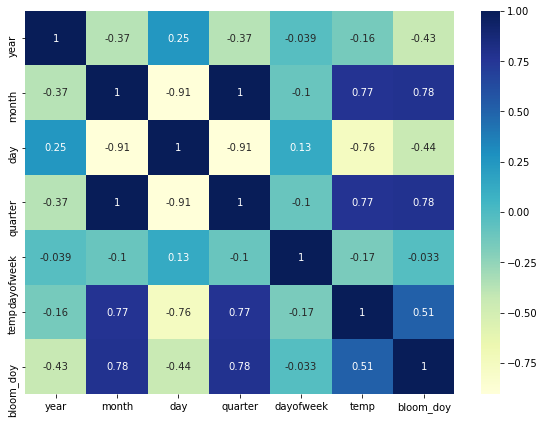

In [1034]:
plt.figure(figsize = (8,6))
sns.heatmap(dc_corr[['year','month', 'day', 'quarter', 'dayofweek', 'temp', 'bloom_doy']].corr(),cmap='YlGnBu',annot=True)

From the above correlation plot, we see that Quarter and Month shows strong positive correlation with bloom doy. 
If we see temperature, it is showing a correlation coefficient of 0.51 which is although not very strong but provides some confidence to predict bloom doy with respect to temperature.
(For readers, Correlation Coefficient value close to 1 means strong positive correlation between variables and 0 means no correlation between variables)

### Timeline snapshot with bloom day of year with temperature

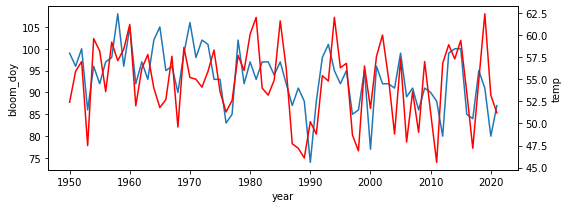

In [314]:
plt.figure(figsize = (8,3))
ax = sns.lineplot(x="year", y="bloom_doy", data=dc_corr)
ax2 = ax.twinx()
sns.lineplot(x="year", y="temp", ax=ax2, legend=False, color="r", data=dc_corr)
plt.show()

From the above timeline plot, we can notice that most of the years showing higher temperature with longer bloom doy. So we finally decided to go with temperature data

### Machine Learning
#### Long short-term memory (LSTM) algorithm
We use Long short-term memory (LSTM) algorithm which is an artificial recurrent neural network (RNN) architecture and used in the field of deep learning. Long Short-Term Memory (LSTM) are capable of learning order dependence in sequence prediction problems. This is a behavior required in complex problem domains like time series, speech recognition and more. Since we assume that cherry blossom date depends on series of temperature in the past, so learning these patters through LSTM is a good direction for our prediction.

In [139]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
import numpy as np

In [96]:
#using temperature data to predict bloom day of year

# Training Model for Washington DC 

In [960]:
# convert an array of values into a dataset matrix
def create_dataset_4(dataset,dataset2):
    dataX, dataY = [], []
    for i in range(0,len(dataset)-1):
        y = dataset2.loc[dataset2['year']==dataset.iloc[i,0]]
        y2 = y['bloom_doy'].values[0]
        x = dataset.iloc[i,1:].append(y['bloom_doy'], ignore_index=True)
        dataX.append(x)
        dataY.append(y2)
    return dataX, dataY

Below is the snapshot of our temperature data

In [1036]:
X, Y = create_dataset_4(dc_temp, dc)
dataset = pd.DataFrame(X)
dataset.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','bloom_doy']
dataset.head(5)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,bloom_doy
0,47.9,38.6,41.7,52.4,64.5,73.9,76.1,75.6,66.9,61.0,47.9,35.5,99.0
1,39.3,38.5,45.5,55.9,64.9,73.4,78.7,76.8,70.3,62.1,44.1,40.9,96.0
2,40.7,41.1,43.3,57.0,64.2,76.9,80.5,76.1,68.9,55.3,48.2,38.8,100.0
3,40.7,42.6,47.5,56.1,70.0,74.6,79.6,76.3,69.7,60.5,48.1,40.9,86.0
4,35.9,43.5,44.5,59.6,62.6,74.4,78.7,75.2,73.3,62.0,45.2,37.1,96.0


Step size for LSTM. Step size tells the model how many years to investigate all together in order to predict the next record. We choose to look at 10 years of data at a time and do a sliding window of one year for the rest of the data. For example, LSTM will start with data from 1950 to 1960 and then try to predict 1961 data. Then it will take data from 1951 to 1961 and predict 1962 data and so on.

In [870]:
steps = 10

#### Whole process of Training and Testing the model

In [872]:
# We want 80% of the data to be used for training, and 20% for testing
# Split into train and test sets but keep all 13 columns
# The total rows of the two datasets should equal the total amount of rows in original dataset

n_train_rows = int(dataset.shape[0]*0.8)-1
train = dataset.iloc[:n_train_rows, :]
test = dataset.iloc[n_train_rows:, :]

print(train.shape)
print(test.shape)

# Normalise features
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train.values)
test_set_scaled = sc.fit_transform(test.values)

# Prepare the training data
x_train = []
y_train = []

for i in range(steps, training_set_scaled.shape[0]-steps):
    x_train.append(training_set_scaled[i-steps:i, :])
    y_train.append(training_set_scaled[i, :])

x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)

# Prepare the test data
x_test = []
y_test = []

for i in range(steps, test_set_scaled.shape[0]):
    x_test.append(test_set_scaled[i-steps:i, :])
    y_test.append(test_set_scaled[i, :])

x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)

(56, 13)
(16, 13)
(36, 10, 13)
(6, 10, 13)


In [989]:
def TrainLSTM(x_train, y_train):
    model = Sequential()
    epochs = 1000
    u = 64
    model.add(LSTM(units=u, return_sequences = True, input_shape = (x_train.shape[1],13)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=u, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=u, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=u))
    model.add(Dropout(0.2))
    model.add(Dense(units=13))
    model.compile(loss="mean_squared_logarithmic_error", optimizer='adam')
    model.fit(x_train, y_train, batch_size = 1, epochs = epochs, verbose=0)
    model.summary
    return model

In [874]:
model = TrainLSTM(x_train, y_train)
model.history.history['loss'][-1]

0.001206118962727487

In [876]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=32)
print('test loss, test acc:', results)


# Evaluate on test data
1/1 [==============================] - 0s 33ms/step - loss: 0.0591
test loss, test acc: 0.059051986783742905


Since model looks good, lets train on whole data

In [962]:
n_train_rows = int(dataset.shape[0]*1)
train = dataset.iloc[:n_train_rows, :]
# Normalise features
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train.values)
# Prepare the training data
x_train = []
y_train = []
for i in range(steps, training_set_scaled.shape[0]-steps):
    x_train.append(training_set_scaled[i-steps:i, :])
    y_train.append(training_set_scaled[i, :])
x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)

(52, 10, 13)


In [885]:
model = TrainLSTM(x_train, y_train)
model.history.history['loss'][-1]

0.0013354795519262552

#### Now the training is complete, we are ready to predict Bloom year of day for the upcoming years

In [963]:
# Predicting Bloom year of day for upcoming years
def moving_test_window_preds(model, data, start, n_future_preds):
    
    # Declare variable where we store the prediction made on each window and the moving input window
    prediction = [] 
    moving_input_window = []
    
    # Set the inputs
    inputs = data.reset_index(drop=True).values
    inputs = sc.transform(inputs)

    moving_input_window.append(inputs[start:(start+steps), :])
    moving_input_window = np.array(moving_input_window)
    moving_input_window = np.reshape(moving_input_window, (moving_input_window.shape[0], moving_input_window.shape[1], 13))
    
    # Loop over the amount of future predictions we want to make
    for i in range(n_future_preds):
        
        # Predict the next price based on the moving_input_window
        y_hat = model.predict(moving_input_window)
        
        # Append y_hat to predictions
        prediction.append(y_hat[0,:])
        
        # Reshape y_hat for concatenation with moving test window
        y_hat = y_hat.reshape(1,1,13) 
        
        # Remove first element
        moving_input_window = np.concatenate((moving_input_window[:,1:,:], y_hat),axis=1)

    prediction = sc.inverse_transform(pd.DataFrame(prediction))
    
    return prediction

In [964]:
data = train.iloc[n_train_rows-steps:,:]
n_future_preds = 10
prediction = moving_test_window_preds(model, data,0,n_future_preds)
pred = np.floor(prediction[:,-1]+0.5)
p = pd.DataFrame(pred)
p = (p[0]).astype('int')
last_ten_years = data['bloom_doy'].astype(int)
last_ten_years
p_dc = last_ten_years.append(p)

# Training Model for Koyto

In [990]:
X, Y = create_dataset_4(kyoto_temp, kyoto)
dataset = pd.DataFrame(X)
dataset.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','bloom_doy']

In [991]:
n_train_rows = int(dataset.shape[0]*1)
train = dataset.iloc[:n_train_rows, :]
# Normalise features
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train.values)
# Prepare the training data
x_train = []
y_train = []
for i in range(steps, training_set_scaled.shape[0]-steps):
    x_train.append(training_set_scaled[i-steps:i, :])
    y_train.append(training_set_scaled[i, :])
x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)

(52, 10, 13)


In [992]:
model2 = TrainLSTM(x_train, y_train)
model2.history.history['loss'][-1]

0.0011748519027605653

In [993]:
data = train.iloc[n_train_rows-steps:,:]
n_future_preds = 10
prediction = moving_test_window_preds(model2,data,0,n_future_preds)
pred = np.floor(prediction[:,-1]+0.5)
p = pd.DataFrame(pred)
p = (p[0]).astype('int')
last_ten_years = data['bloom_doy'].astype(int)
last_ten_years
p_kyoto = last_ten_years.append(p)

# Training Model for Leistal

In [999]:
X, Y = create_dataset_4(liestal_temp, liestal)
dataset = pd.DataFrame(X)
dataset.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','bloom_doy']

In [1000]:
n_train_rows = int(dataset.shape[0]*1)
train = dataset.iloc[:n_train_rows, :]
# Normalise features
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train.values)
# Prepare the training data
x_train = []
y_train = []
for i in range(steps, training_set_scaled.shape[0]-steps):
    x_train.append(training_set_scaled[i-steps:i, :])
    y_train.append(training_set_scaled[i, :])
x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)

(52, 10, 13)


In [1001]:
model3 = TrainLSTM(x_train, y_train)
model3.history.history['loss'][-1]

0.006005192641168833

In [1003]:
data = train.iloc[n_train_rows-steps:,:]
n_future_preds = 10
prediction = moving_test_window_preds(model3,data,0,n_future_preds)
pred = np.floor(prediction[:,-1]+0.5)
p = pd.DataFrame(pred)
p = (p[0]).astype('int')
last_ten_years = data['bloom_doy'].astype(int)
last_ten_years
p_liestal = last_ten_years.append(p)

# Training Model for Vancouver

In [1011]:
X, Y = create_dataset_4(vancouver_temp, vancouver)
dataset = pd.DataFrame(X)
dataset.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','bloom_doy']

In [1012]:
n_train_rows = int(dataset.shape[0]*1)
train = dataset.iloc[:n_train_rows, :]
# Normalise features
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train.values)
# Prepare the training data
x_train = []
y_train = []
for i in range(steps, training_set_scaled.shape[0]-steps):
    x_train.append(training_set_scaled[i-steps:i, :])
    y_train.append(training_set_scaled[i, :])
x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)

(52, 10, 13)


In [781]:
model = TrainLSTM(x_train, y_train)
model.history.history['loss'][-1]

0.0018822824349626899

In [1013]:
data = train.iloc[n_train_rows-steps:,:]
n_future_preds = 10
prediction = moving_test_window_preds(model,data,0,n_future_preds)
pred = np.floor(prediction[:,-1]+0.5)
p = pd.DataFrame(pred)
p = (p[0]).astype('int')
last_ten_years = data['bloom_doy'].astype(int)
last_ten_years
p_vancouver = last_ten_years.append(p)

In [1014]:
years = list(range(2012,2032))

In [1015]:
final = pd.DataFrame(list(zip(years,p_kyoto,p_liestal,p_dc,p_vancouver)),
                     columns = ['year','kyoto','liestal','washingtondc','vancouver'])

### Final Predictions with some timeline plot
We plotted last 10 years of bloom doy with next 10 year bloom doy. Blue color represents actual bloom doy and red color represents next 1o years prediction

### Washington DC Predictions

 <img src="data/images/dc.jpg" style="width: 400px; height: 200px;"/>

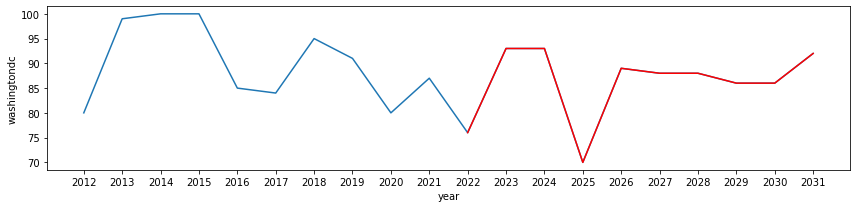

In [1017]:
plt.figure(figsize = (12,3))
ax1 = plt.subplot(111)
sns.lineplot(x="year", y="washingtondc", data=final,ax=ax1)
sns.lineplot(x="year", y="washingtondc", legend=False, color="r", data=final.iloc[10:,], ax=ax1)
plt.xticks(final['year'])
plt.show()

### Kyoto Predictions

 <img src="data/images/kyoto.jpg" style="width: 400px; height: 200px;"/>

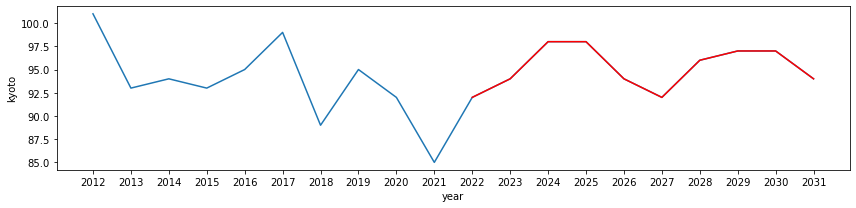

In [1018]:
plt.figure(figsize = (12,3))
ax1 = plt.subplot(111)
sns.lineplot(x="year", y="kyoto", data=final,ax=ax1)
sns.lineplot(x="year", y="kyoto", legend=False, color="r", data=final.iloc[10:,], ax=ax1)
plt.xticks(final['year'])
plt.show()

### Liestal Predictions

 <img src="data/images/liestal.jpg" style="width: 400px; height: 200px;"/>

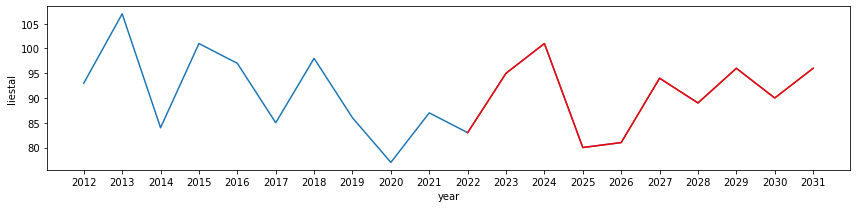

In [1019]:
plt.figure(figsize = (12,3))
ax1 = plt.subplot(111)
sns.lineplot(x="year", y="liestal", data=final,ax=ax1)
sns.lineplot(x="year", y="liestal", legend=False, color="r", data=final.iloc[10:,], ax=ax1)
plt.xticks(final['year'])
plt.show()

### Vancouver Predictions

 <img src="data/images/vancouver.jpg" style="width: 400px; height: 200px;"/>

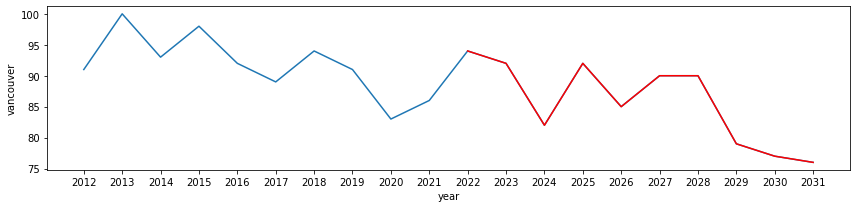

In [1020]:
plt.figure(figsize = (12,3))
ax1 = plt.subplot(111)
sns.lineplot(x="year", y="vancouver", data=final,ax=ax1)
sns.lineplot(x="year", y="vancouver", legend=False, color="r", data=final.iloc[10:,], ax=ax1)
plt.xticks(final['year'])
plt.show()

### Below is the predicted bloom doy for all the locations

In [1021]:
final.iloc[10:,]

,year,kyoto,liestal,washingtondc,vancouver
10,2022,92,83,76,94
11,2023,94,95,93,92
12,2024,98,101,93,82
13,2025,98,80,70,92
14,2026,94,81,89,85
15,2027,92,94,88,90
16,2028,96,89,88,90
17,2029,97,96,86,79
18,2030,97,90,86,77
19,2031,94,96,92,76


### Exporting results to csv file for submission

In [1023]:
final.iloc[10:,].to_csv('cherry-predictions.csv',index=False)

#### The code is written in Python. Due to shortage of time, I could not do it in R but this code can easily be developed in R.
#### Happy coding !